# Part 3: A Pre-trained Model


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification,  TrainingArguments, Trainer
from datasets import Dataset, Image, Value, ClassLabel, Features

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
base_dir = "../input/dogsvscatsreduxkernelsedition"
train_dir = os.path.join(base_dir, "train/train")

## Label Images and Create File DataFrame
We'll do the usual task and load our images into a dataframe and label them using the images name.

In [2]:
pd.set_option('max_colwidth', 60)
train_filenames = os.listdir(base_dir+ '/train/train')
train_data = pd.DataFrame(columns=['image', 'labels'])
train_data['image'] = train_filenames 
train_data['labels'] = train_data['image'].str[0:3].map({"cat":0,"dog":1})
train_data['image'] = (train_dir +"/" +train_data['image']).astype(str)
train_data.head()

,image,labels
0,../input/dogsvscatsreduxkernelsedition/train/train/cat.1...,0
1,../input/dogsvscatsreduxkernelsedition/train/train/dog.3...,1
2,../input/dogsvscatsreduxkernelsedition/train/train/dog.7...,1
3,../input/dogsvscatsreduxkernelsedition/train/train/dog.1...,1
4,../input/dogsvscatsreduxkernelsedition/train/train/dog.1...,1


In [3]:
train_data.shape

(25000, 2)

We'll use the data in our dataframe above to a create a new dataset object.

In [4]:
features = Features({"image": Value("string"), "labels": ClassLabel(num_classes=2, names=["cat","dog"])})
ds_raw = Dataset.from_pandas(train_data[['labels','image']],features=features).cast_column('image', Image())
ds_raw

Dataset({
    features: ['image', 'labels'],
    num_rows: 25000
})

In [5]:
ex = ds_raw[2]
ex 

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x359>,
 'labels': 1}

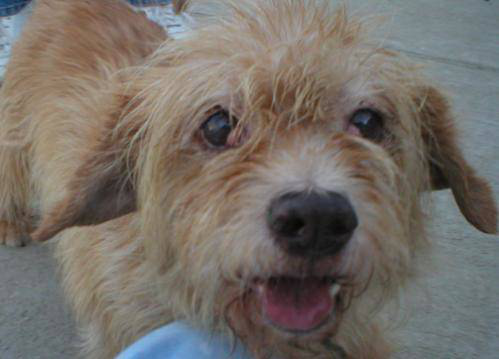

In [6]:
image = ex['image']
image

In [7]:
ds_raw.features

{'image': Image(decode=True, id=None),
 'labels': ClassLabel(num_classes=2, names=['cat', 'dog'], id=None)}

In [8]:
labels = ds_raw.features['labels']
labels

ClassLabel(num_classes=2, names=['cat', 'dog'], id=None)

## Prepare images for our model

When we train a Vision Transformer(ViT), specific transformation are applied to images fed into them. If the transformation is done wrong, the model won't be able to understand what it's seeing. In order to do this, we'll need to set up our ViTFeatureExtractor based on our pre-trained model. 

In [9]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

We can take a quick look at how the feature extractor process an image

In [10]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.8353, -0.8667, -0.8353,  ..., -0.2000, -0.2078, -0.2157],
          [-0.7725, -0.7804, -0.8118,  ..., -0.2000, -0.1843, -0.1922],
          [-0.6941, -0.7176, -0.7490,  ..., -0.1843, -0.1686, -0.1765],
          ...,
          [-0.1451, -0.1451, -0.1294,  ..., -0.1608, -0.1686, -0.1843],
          [-0.1608, -0.1294, -0.1294,  ..., -0.1686, -0.1843, -0.1843],
          [-0.1843, -0.1373, -0.1451,  ..., -0.1922, -0.2235, -0.2314]],

         [[-0.4353, -0.4824, -0.4902,  ..., -0.0667, -0.0667, -0.0510],
          [-0.3961, -0.4275, -0.4824,  ..., -0.0667, -0.0431, -0.0431],
          [-0.3647, -0.4039, -0.4510,  ..., -0.0510, -0.0431, -0.0510],
          ...,
          [-0.0588, -0.0667, -0.0510,  ..., -0.0588, -0.0510, -0.0510],
          [-0.0745, -0.0510, -0.0510,  ..., -0.0667, -0.0667, -0.0510],
          [-0.0980, -0.0510, -0.0667,  ..., -0.0902, -0.1059, -0.0980]],

         [[-0.1373, -0.1922, -0.2078,  ..., -0.0118, -0.0118, -0.0118],
          [-0

Now that you know how to read images and transform them into inputs, let's write a function that will put those two things together to process all the images from our dataset.

In [11]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch["image"]], return_tensors='pt')

    # Don't forget to include the labels!
    inputs["labels"] = example_batch["labels"]
    return inputs

In [12]:
prepared_ds = ds_raw.with_transform(transform)
prepared_ds[0:2]

{'pixel_values': tensor([[[[ 0.5686,  0.5686,  0.5529,  ...,  0.6549,  0.6549,  0.6549],
          [ 0.5843,  0.5922,  0.5843,  ...,  0.6549,  0.6549,  0.6549],
          [ 0.5765,  0.6000,  0.6000,  ...,  0.6549,  0.6549,  0.6549],
          ...,
          [ 0.2784,  0.1529,  0.1686,  ...,  0.4039,  0.4196,  0.4118],
          [ 0.2000,  0.1451,  0.0980,  ...,  0.4039,  0.4275,  0.4118],
          [ 0.1137, -0.0353, -0.3412,  ...,  0.4118,  0.4431,  0.4353]],

         [[ 0.2863,  0.2863,  0.2706,  ...,  0.3725,  0.3725,  0.3725],
          [ 0.3020,  0.3098,  0.3020,  ...,  0.3725,  0.3725,  0.3725],
          [ 0.2941,  0.3176,  0.3098,  ...,  0.3725,  0.3725,  0.3725],
          ...,
          [ 0.1294,  0.0039,  0.0275,  ...,  0.1451,  0.1608,  0.1529],
          [ 0.1059,  0.0588,  0.0039,  ...,  0.1373,  0.1529,  0.1451],
          [ 0.0510, -0.0824, -0.3961,  ...,  0.1294,  0.1608,  0.1529]],

         [[ 0.1765,  0.1765,  0.1843,  ...,  0.2471,  0.2471,  0.2471],
          [ 0

## Training and Evaluation

In [13]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

We'll use accuracy as our evaluation metric

In [14]:
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [15]:
from transformers import ViTForImageClassification

labels = ds_raw.features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
for name,param in model.named_parameters():
    print(name,param.requires_grad)

vit.embeddings.cls_token True
vit.embeddings.position_embeddings True
vit.embeddings.patch_embeddings.projection.weight True
vit.embeddings.patch_embeddings.projection.bias True
vit.encoder.layer.0.attention.attention.query.weight True
vit.encoder.layer.0.attention.attention.query.bias True
vit.encoder.layer.0.attention.attention.key.weight True
vit.encoder.layer.0.attention.attention.key.bias True
vit.encoder.layer.0.attention.attention.value.weight True
vit.encoder.layer.0.attention.attention.value.bias True
vit.encoder.layer.0.attention.output.dense.weight True
vit.encoder.layer.0.attention.output.dense.bias True
vit.encoder.layer.0.intermediate.dense.weight True
vit.encoder.layer.0.intermediate.dense.bias True
vit.encoder.layer.0.output.dense.weight True
vit.encoder.layer.0.output.dense.bias True
vit.encoder.layer.0.layernorm_before.weight True
vit.encoder.layer.0.layernorm_before.bias True
vit.encoder.layer.0.layernorm_after.weight True
vit.encoder.layer.0.layernorm_after.bias Tru

In [17]:
prepared_ds

Dataset({
    features: ['image', 'labels'],
    num_rows: 25000
})

In [18]:
train_prop = 0.85
ds_train = prepared_ds.select(range(int(len(prepared_ds)*train_prop)))
ds_eval = prepared_ds.select(range(int(len(prepared_ds)*train_prop), len(prepared_ds)))

In [19]:
print(f"len(ds_train) = {len(ds_train)}")
print(f"len(ds_eval) = {len(ds_eval)}")

len(ds_train) = 21250
len(ds_eval) = 3750


In [20]:
os.environ["WANDB_DISABLED"] = "true"

For model Tuning/Evaluation, I've tried epochs[1-5], increasing/decreasing learning rate, batch size[3-10],etc. Since our model has been trained on the imagenet 21k dataset, no matter how much I try to change the training arguments it would still perform well above 99% accuracy. The dataset it was trained on have 14 million images and 21,843 classes. I've done some research on that dataset and not only does it contain cat and dog classes but it also contain multiple breeds of cat and dogs. Since our dataset is very similar to data model was pre-trained on, it perform extremely well. This is kind of lame since we didn't get to train the model at all, technically. Thus, I'll try to freeze some layers close to input and retrain some of the later layers in project part 3.2.

In [21]:
training_args = TrainingArguments(num_train_epochs=1,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=10,
                                  evaluation_strategy="steps",
                                  eval_steps=500,
                                  learning_rate= 8e-07,
                                  do_train=True,
                                  report_to=None,
                                  output_dir="/kaggle/working",
                                  remove_unused_columns=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset= ds_train,
    eval_dataset= ds_eval,
    tokenizer=feature_extractor,
)
train_results = trainer.train()
trainer.evaluate(ds_eval)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 21250
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2125


Step,Training Loss,Validation Loss,Accuracy
500,0.589000,0.499355,0.976533
1000,0.428300,0.359561,0.994933
1500,0.314300,0.276758,0.995467
2000,0.257500,0.246126,0.995467


***** Running Evaluation *****
  Num examples = 3750
  Batch size = 10
Saving model checkpoint to /kaggle/working/checkpoint-500
Configuration saved in /kaggle/working/checkpoint-500/config.json
Model weights saved in /kaggle/working/checkpoint-500/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-500/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 3750
  Batch size = 10
Saving model checkpoint to /kaggle/working/checkpoint-1000
Configuration saved in /kaggle/working/checkpoint-1000/config.json
Model weights saved in /kaggle/working/checkpoint-1000/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 3750
  Batch size = 10
Saving model checkpoint to /kaggle/working/checkpoint-1500
Configuration saved in /kaggle/working/checkpoint-1500/config.json
Model weights saved in /kaggle/working/checkpoint-1500/pytorch_model.bin
Feature extractor saved in

{'eval_loss': 0.2449859380722046,
 'eval_accuracy': 0.9957333333333334,
 'eval_runtime': 50.2949,
 'eval_samples_per_second': 74.56,
 'eval_steps_per_second': 7.456,
 'epoch': 1.0}